# **Task file of Transformer based model : XLM**

In [1]:
# mount drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# **Necessary libraries**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import MultiLabelBinarizer
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import roc_curve, auc
import transformers
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

#**Load dataset(Train,Validation,Test**

In [3]:
# Load the datasets
import pandas as pd
train_df = pd.read_csv('/content/drive/MyDrive/SM files/train.csv')
validation_df = pd.read_csv('/content/drive/MyDrive/SM files/validation.csv')
test_df = pd.read_csv('/content/drive/MyDrive/SM files/test.csv')
test_labels_df = pd.read_csv('/content/drive/MyDrive/SM files/test_labels.csv')


train_df.head()

,id,feedback_text,toxic,abusive,vulgar,menace,offense,bigotry
0,281d77b7bebc2201,:::Sounds good. Let me know when you're done ...,0,0,0,0,0,0
1,716aac7bf3c63db1,"""\nI say something, but it didn't actually con...",0,0,0,0,0,0
2,57cb318c6edcf10c,"""Agustina Barrientos]] \n | Modelo de Piñeiro ...",0,0,0,0,0,0
3,dc3bd70118d91b3a,FYI I enjoy licking strangers scrotal sacks......,1,0,1,0,0,0
4,cf10d41f2997d233,How do you get a site?\nMany penguins have ask...,0,0,0,0,0,0


# **Exploratory Data Analysis**



1. Visualize label distribution across all toxicity types
1. Analyze sentence structure (length, word distribution, common words)
3. Check for missing values or outliers


In [4]:
print(train_df.columns)

print(train_df.info())

Index(['id', 'feedback_text', 'toxic', 'abusive', 'vulgar', 'menace',
       'offense', 'bigotry'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23473 entries, 0 to 23472
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             23473 non-null  object
 1   feedback_text  23473 non-null  object
 2   toxic          23473 non-null  int64 
 3   abusive        23473 non-null  int64 
 4   vulgar         23473 non-null  int64 
 5   menace         23473 non-null  int64 
 6   offense        23473 non-null  int64 
 7   bigotry        23473 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 1.4+ MB
None


## Missing values and Descriptive Statistics


In [5]:
print("Dataset Shape:", train_df.shape)
print("Columns in the Dataset:", train_df.columns)
print("Basic Info:")
train_df.info()

# Checking for missing values
missing_values = train_df.isnull().sum()
print("\nMissing Values:")
print(missing_values)

# Descriptive statistics for numerical columns
numerical_desc = train_df.describe()
print("\nDescriptive Statistics:")
print(numerical_desc)


Dataset Shape: (23473, 8)
Columns in the Dataset: Index(['id', 'feedback_text', 'toxic', 'abusive', 'vulgar', 'menace',
       'offense', 'bigotry'],
      dtype='object')
Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23473 entries, 0 to 23472
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             23473 non-null  object
 1   feedback_text  23473 non-null  object
 2   toxic          23473 non-null  int64 
 3   abusive        23473 non-null  int64 
 4   vulgar         23473 non-null  int64 
 5   menace         23473 non-null  int64 
 6   offense        23473 non-null  int64 
 7   bigotry        23473 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 1.4+ MB

Missing Values:
id               0
feedback_text    0
toxic            0
abusive          0
vulgar           0
menace           0
offense          0
bigotry          0
dtype: int64

Descriptive Statistics:
              toxic  

## Distribution of each label (Toxic, Abusive, Vulgar, Menace, Offense, Bigotry)

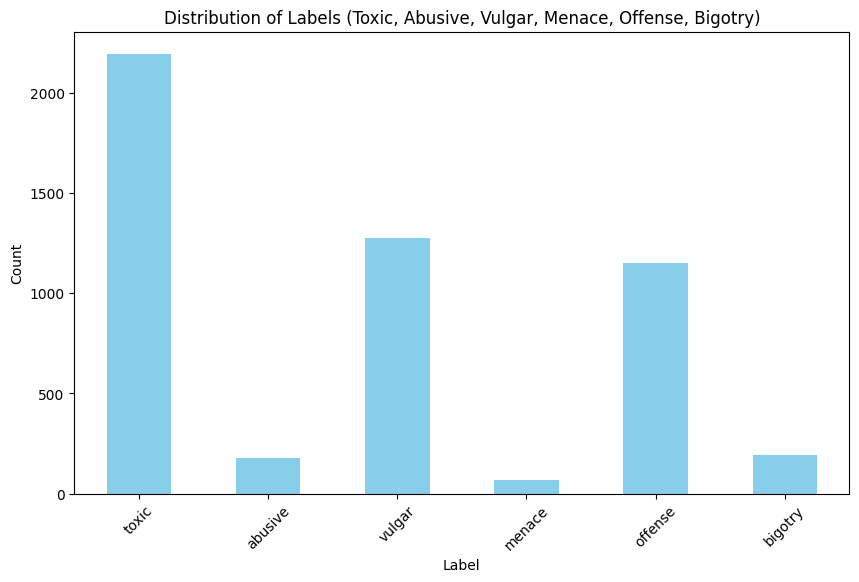

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

labels = ['toxic', 'abusive', 'vulgar', 'menace', 'offense', 'bigotry']

plt.figure(figsize=(10, 6))
train_df[labels].sum().plot(kind='bar', color='skyblue')
plt.title('Distribution of Labels (Toxic, Abusive, Vulgar, Menace, Offense, Bigotry)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

## Creating pie charts for each label's distribution (1's and 0's)

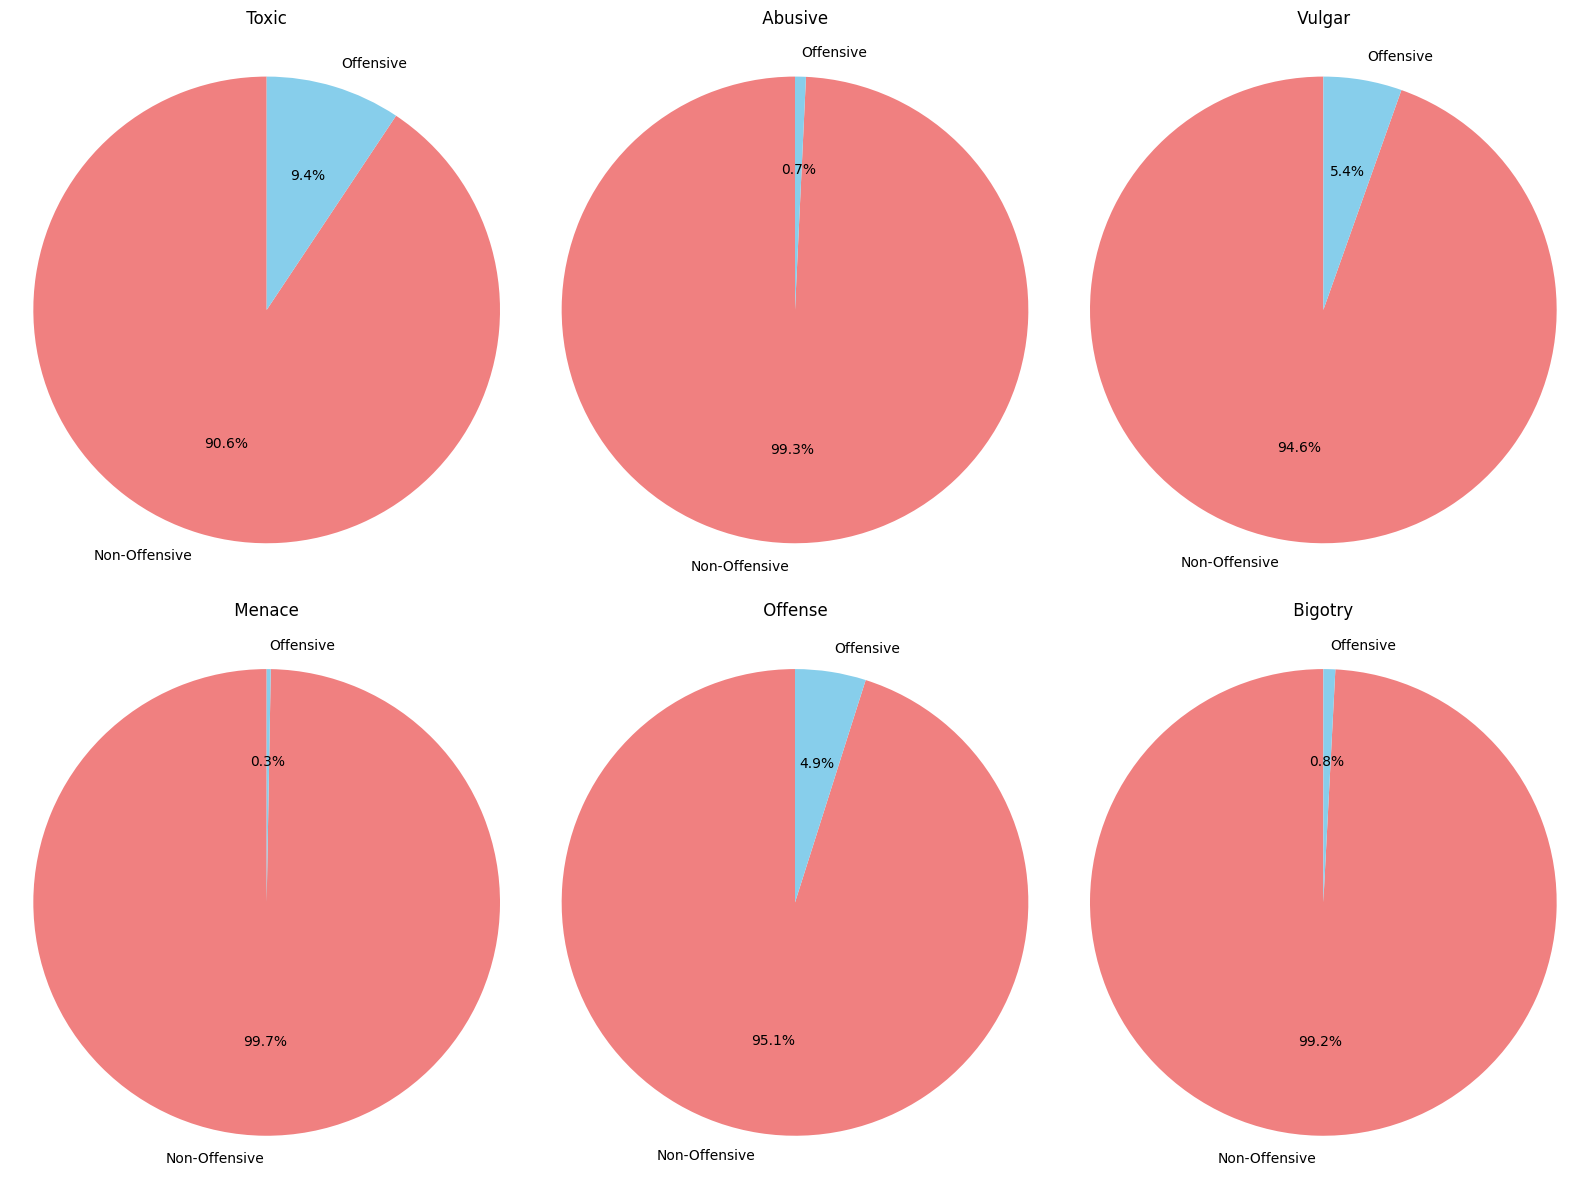

In [7]:
import matplotlib.pyplot as plt

labels = ['toxic', 'abusive', 'vulgar', 'menace', 'offense', 'bigotry']

plt.figure(figsize=(16, 12))
for i, label in enumerate(labels):
    plt.subplot(2, 3, i+1)
    label_counts = train_df[label].value_counts()
    plt.pie(label_counts, labels=['Non-Offensive', 'Offensive'], autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'skyblue'])
    plt.title(f' {label.capitalize()} ')
    plt.axis('equal')

plt.tight_layout()
plt.show()


## Sentence Length of feedback_text

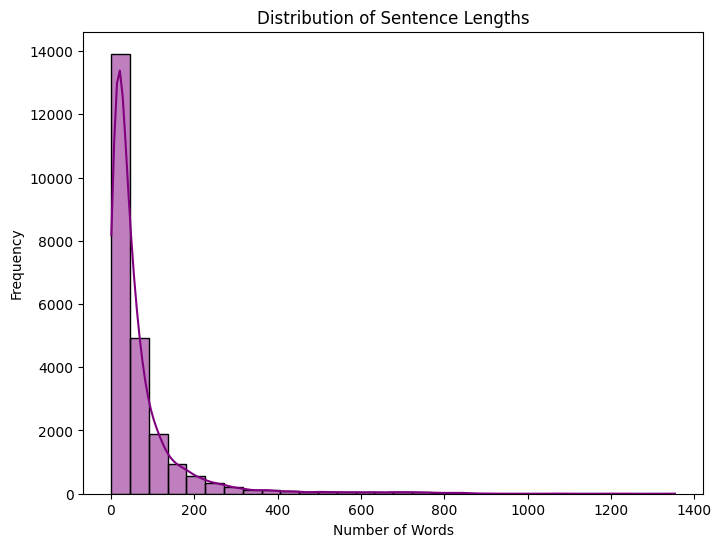

Average Sentence Length: 68.26 words


In [8]:
train_df['sentence_length'] = train_df['feedback_text'].apply(lambda x: len(x.split()))


plt.figure(figsize=(8, 6))
sns.histplot(train_df['sentence_length'], bins=30, kde=True, color='purple')
plt.title('Distribution of Sentence Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

# Average Sentence Length
avg_sentence_length = train_df['sentence_length'].mean()
print(f"Average Sentence Length: {avg_sentence_length:.2f} words")


## Correlation matrix for each features

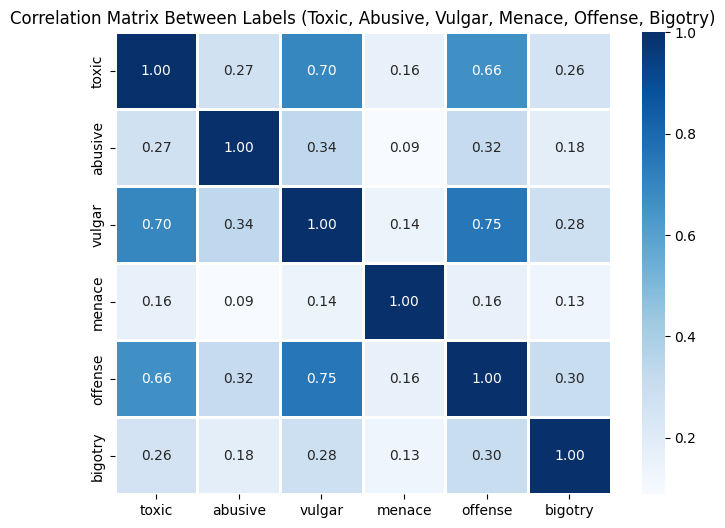

In [9]:
corr_matrix = train_df[labels].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt='.2f', linewidths=1)
plt.title('Correlation Matrix Between Labels (Toxic, Abusive, Vulgar, Menace, Offense, Bigotry)')
plt.show()


## Checking  word cloud

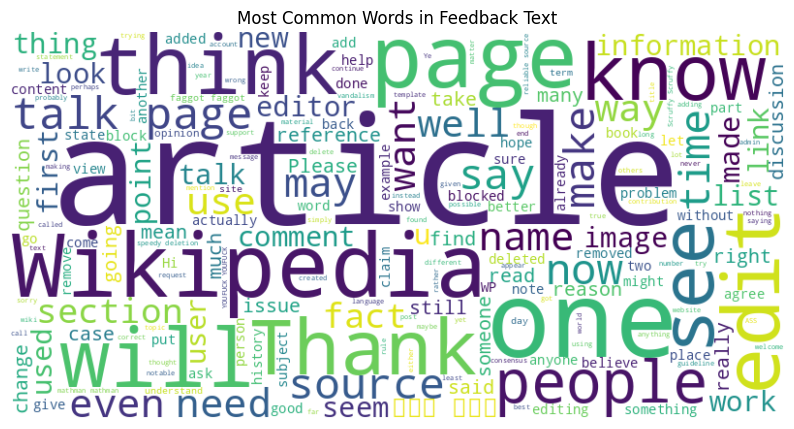

In [10]:
from wordcloud import WordCloud

all_text = ' '.join(train_df['feedback_text'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Plot the word cloud
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Feedback Text')
plt.show()


## Displaying example feedback for each features

In [11]:
print("Example Toxic Feedback:")
print(train_df[train_df['toxic'] == 1]['feedback_text'].head(3))

print("\nExample Abusive Feedback:")
print(train_df[train_df['abusive'] == 1]['feedback_text'].head(3))

print("\nExample Vulgar Feedback:")
print(train_df[train_df['vulgar'] == 1]['feedback_text'].head(3))

print("\nExample Menace Feedback:")
print(train_df[train_df['menace'] == 1]['feedback_text'].head(3))

print("\nExample Offense Feedback:")
print(train_df[train_df['offense'] == 1]['feedback_text'].head(3))

print("\nExample Bigotry Feedback:")
print(train_df[train_df['bigotry'] == 1]['feedback_text'].head(3))


Example Toxic Feedback:
3     FYI I enjoy licking strangers scrotal sacks......
7                                GO GET A IFE DICK SHOW
11    "\n\n""Failed""? Those images fully comply wit...
Name: feedback_text, dtype: object

Example Abusive Feedback:
12     Fucking lying nigger, fes up you peice of shit...
38     == fuck you == \n\n fuck you asshole..freedom ...
163    Take your sandbox \n\nAnd stick it up your ass...
Name: feedback_text, dtype: object

Example Vulgar Feedback:
3     FYI I enjoy licking strangers scrotal sacks......
12    Fucking lying nigger, fes up you peice of shit...
38    == fuck you == \n\n fuck you asshole..freedom ...
Name: feedback_text, dtype: object

Example Menace Feedback:
301        you edit \n\nYOU EDIT IS VANDAL! STOP OR DIE!
503                       hurricane machine to kill him.
902    Urgent!!!! \n\nMind yo own fucken buisiness st...
Name: feedback_text, dtype: object

Example Offense Feedback:
12    Fucking lying nigger, fes up you peice of shit

## Boxplot to visualize sentence length outliers


*   Calculating Z-scores for sentence lengths to identify outliers

*   Calculate Z-scores for sentence length
*   Filter out data points where the absolute Z-score is greater than 3 (common threshold for outliers)

*   Display rows with sentence length outliers



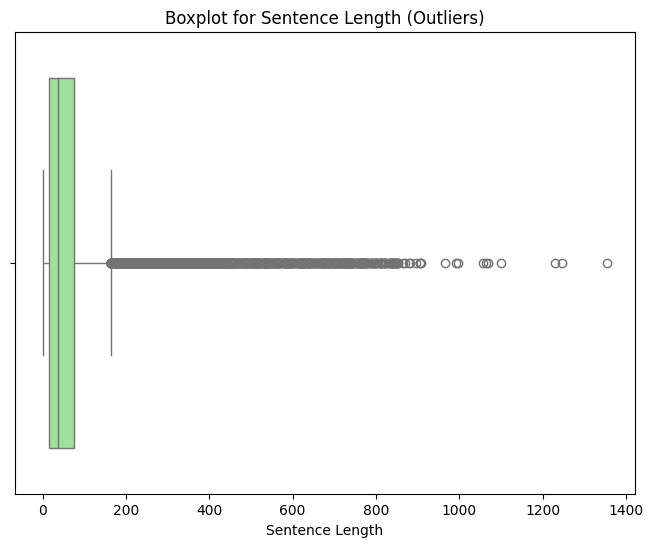

,feedback_text,sentence_length,sentence_length_zscore
34,"""\n\nI am sorry to say Mr.Tosa was not invited...",812,7.195900
200,Quick Question. \n\nI asked you a question 1 m...,405,3.258045
211,"""\n\n Canadian Association for HIV Research \n...",461,3.799863
277,"""\n\nI agree with Demiurge1000. Stanistani, pl...",589,5.038304
306,""" \n\n \n == My wiki stance == \n I have now ...",430,3.499928


In [12]:

train_df['sentence_length'] = train_df['feedback_text'].apply(lambda x: len(x.split()))


plt.figure(figsize=(8, 6))
sns.boxplot(x=train_df['sentence_length'], color='lightgreen')
plt.title('Boxplot for Sentence Length (Outliers)')
plt.xlabel('Sentence Length')
plt.show()


from scipy.stats import zscore

train_df['sentence_length_zscore'] = zscore(train_df['sentence_length'])

outliers_zscore = train_df[train_df['sentence_length_zscore'].abs() > 3]

# Display rows with sentence length outliers
outliers_zscore[['feedback_text', 'sentence_length', 'sentence_length_zscore']].head()


# **Merged Features**




Merge datasets on the common column (assuming 'id' the unique identifier)  



In [8]:
import pandas as pd
test_df = pd.read_csv('/content/drive/MyDrive/SM files/test.csv')
test_labels_df = pd.read_csv('/content/drive/MyDrive/SM files/test_labels.csv')

test_merged_data = pd.merge(test_df, test_labels_df, on='id')

print(test_merged_data.head())


   id                                            content lang  toxic
0   0  Doctor Who adlı viki başlığına 12. doctor olar...   tr      0
1   1   Вполне возможно, но я пока не вижу необходимо...   ru      0
2   2  Quindi tu sei uno di quelli   conservativi  , ...   it      1
3   3  Malesef gerçekleştirilmedi ancak şöyle bir şey...   tr      0
4   4  :Resim:Seldabagcan.jpg resminde kaynak sorunu ...   tr      0


In [9]:
print(test_merged_data.columns)

print(test_merged_data.info())

Index(['id', 'content', 'lang', 'toxic'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       6000 non-null   int64 
 1   content  6000 non-null   object
 2   lang     6000 non-null   object
 3   toxic    6000 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 187.6+ KB
None


# **Preprocessing**

This preprocessing function prepares text data for input into a multilingual BERT model (mBERT). The process begins by converting the text to lowercase to ensure uniformity and eliminate case-based distinctions. Non-alphabetic characters, such as punctuation and special symbols, are removed using a regular expression, while retaining accented characters and spaces to preserve the linguistic richness of various languages. This helps in standardizing the text and focusing only on the words that matter for analysis.

Next, the text is tokenized using the BERT tokenizer, which splits the text into smaller units (tokens) that mBERT can understand, including handling subwords for unknown terms. The tokens are then rejoined into a string for easy input into the model. This preprocessing pipeline ensures that the input is clean, consistent, and ready for the model to effectively process and classify multilingual feedback, particularly for detecting offensive content.

In [10]:
from transformers import BertTokenizer
import re

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

def preprocess_text_bert(text):

    text = text.lower()

    text = re.sub(r'[^a-záéíóúüñ\s]', '', text)


    tokens = tokenizer.tokenize(text)

    processed_text = ' '.join(tokens)
    return processed_text

train_df['processed_text'] = train_df['feedback_text'].apply(preprocess_text_bert)
validation_df['processed_text'] = validation_df['feedback_text'].apply(preprocess_text_bert)
test_merged_data['processed_text'] = test_df['content'].apply(preprocess_text_bert)

train_df[['feedback_text', 'processed_text']].head()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

,feedback_text,processed_text
0,:::Sounds good. Let me know when you're done ...,sounds good let me know when your ##e done and...
1,"""\nI say something, but it didn't actually con...",i say something but it didn ##t actually con #...
2,"""Agustina Barrientos]] \n | Modelo de Piñeiro ...",agus ##tina barri ##entos modelo de pi ##ñeiro...
3,FYI I enjoy licking strangers scrotal sacks......,f ##yi i enjoy li ##cking strange ##rs s ##cro...
4,How do you get a site?\nMany penguins have ask...,how do you get a site many pen ##guin ##s have...


In [11]:
validation_df[['feedback_text', 'processed_text']].head()

,feedback_text,processed_text
0,İyi tamam olabilir. Balkanlar maddesini gelişt...,iyi tam ##am olabilir bal ##kan ##lar ma ##dde...
1,"Por dios, y la canción de John Lennon: http://...",por dios y la canción de jo ##hn len ##non htt...
2,Selam. Öncelikle tebrik ederim... Bu arada ken...,sela ##m n ##celi ##kle te ##brik eder ##im bu...
3,Leggiti tutte le discussioni. Magari cancellal...,leggi ##ti tutte le discussion ##i maga ##ri c...
4,A LAS TOKITAS NOS VALE QUE LAS JONATICAS INSUL...,a las tok ##itas nos vale que las jo ##nati ##...


In [12]:
test_merged_data[['content', 'processed_text']].head()

,content,processed_text
0,Doctor Who adlı viki başlığına 12. doctor olar...,doctor who ad ##l vik ##i bal ##na doctor olar...
1,"Вполне возможно, но я пока не вижу необходимо...",
2,"Quindi tu sei uno di quelli conservativi , ...",quindi tu sei uno di quelli conserva ##tivi ch...
3,Malesef gerçekleştirilmedi ancak şöyle bir şey...,males ##ef ger ##ek ##leti ##ril ##medi ancak ...
4,:Resim:Seldabagcan.jpg resminde kaynak sorunu ...,res ##im ##sel ##dab ##ag ##can ##j ##p ##g re...


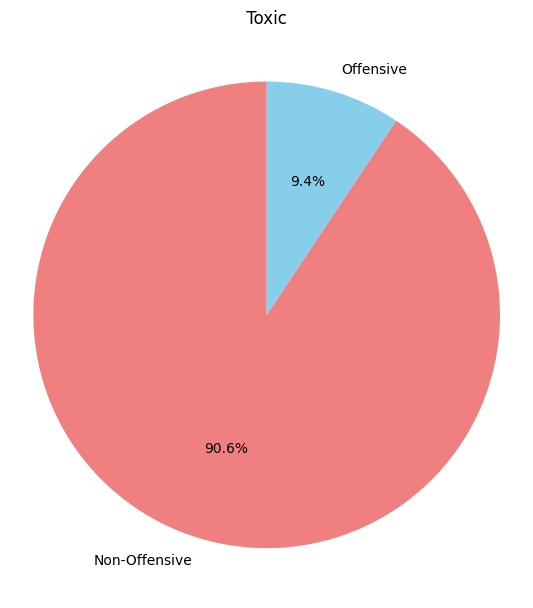

In [13]:

import matplotlib.pyplot as plt

labels = ['toxic']

plt.figure(figsize=(16, 12))
for i, label in enumerate(labels):
    plt.subplot(2, 3, i+1)
    label_counts = train_df[label].value_counts()
    plt.pie(label_counts, labels=['Non-Offensive', 'Offensive'], autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'skyblue'])
    plt.title(f' {label.capitalize()} ')
    plt.axis('equal')

plt.tight_layout()
plt.show()


# **Defining the Features and Target label**




1.   'train_df', 'validation_df', and 'test_df' are the dataframes that containing the features and target labels

1.  Define the features (X) and target labels (y)
2. Define the target labels (y) for each dataset


2.   TF-IDF features for training , validation and testing



In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer # Import the TfidfVectorizer

vectorizer = TfidfVectorizer()

X_train_tfidf = vectorizer.fit_transform(train_df['processed_text'])
X_validation_tfidf = vectorizer.transform(validation_df['processed_text'])
X__test_merged_data_tfidf = vectorizer.transform(test_merged_data['processed_text'])

y_train = train_df['toxic']
y_validation = validation_df['toxic']
y_test_merged_data = test_merged_data['toxic']

In [16]:
pip install transformers


# **Text Data loader**




*   Tokenize the data (train, validation, and test sets)
*   Convert to Dataset format (PyTorch)
*   Creating  DataLoader











In [38]:
from transformers import XLMRobertaTokenizer
import torch
from torch.utils.data import Dataset, DataLoader


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Tokenize the data (train, validation, and test sets)
train_encodings = tokenizer(list(train_df['processed_text']), padding=True, truncation=True, max_length=256)
validation_encodings = tokenizer(list(validation_df['processed_text']), padding=True, truncation=True, max_length=256)
test_encodings = tokenizer(list(test_merged_data['processed_text']), padding=True, truncation=True, max_length=256)

# Convert to Dataset format (PyTorch)
train_dataset = TextDataset(train_df['processed_text'], train_df['toxic'], tokenizer, max_len=256)
validation_dataset = TextDataset(validation_df['processed_text'], validation_df['toxic'], tokenizer, max_len=256)
test_dataset = TextDataset(test_merged_data['processed_text'], test_merged_data['toxic'], tokenizer, max_len=256)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)


#**Transformer-Based Models: XLM**

In [39]:
from transformers import Trainer, TrainingArguments
from transformers import XLMRobertaForSequenceClassification


model = XLMRobertaForSequenceClassification.from_pretrained('xlm-roberta-base', num_labels=2)


model.to(device)


training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    load_best_model_at_end=True,
    save_strategy="epoch"
)

# Initialize the Trainer object
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset
)

trainer.train()


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.247100,0.529758
2,0.135500,0.522025
3,0.154000,0.551353


TrainOutput(global_step=4404, training_loss=0.2030269423978476, metrics={'train_runtime': 3492.7507, 'train_samples_per_second': 20.161, 'train_steps_per_second': 1.261, 'total_flos': 9264008703697920.0, 'train_loss': 0.2030269423978476, 'epoch': 3.0})

Evaluation on validation dataset

Validation Accuracy: 0.8393
Classification Report on Validation Data:
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       706
           1       0.48      0.07      0.13       134

    accuracy                           0.84       840
   macro avg       0.66      0.53      0.52       840
weighted avg       0.79      0.84      0.79       840

Validation ROC-AUC Score: 0.5295


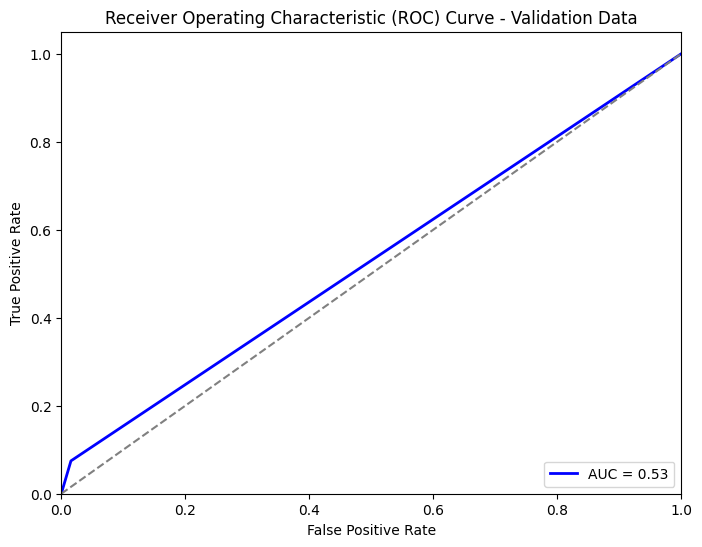

Confusion Matrix on Validation Data:
[[695  11]
 [124  10]]


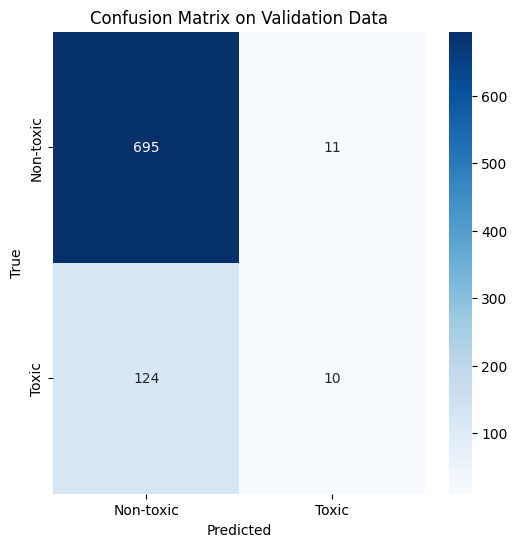

In [41]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# Evaluate on the Validation Data
model.eval()
y_pred_validation = []
y_true_validation = []

with torch.no_grad():
    for batch in validation_loader:

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, predicted = torch.max(outputs.logits, 1)

        y_pred_validation.extend(predicted.cpu().numpy())
        y_true_validation.extend(labels.cpu().numpy())


validation_accuracy = accuracy_score(y_true_validation, y_pred_validation)
print(f"Validation Accuracy: {validation_accuracy:.4f}")


print("Classification Report on Validation Data:")
print(classification_report(y_true_validation, y_pred_validation))


roc_auc_validation = roc_auc_score(y_true_validation, [pred == 1 for pred in y_pred_validation])
print(f"Validation ROC-AUC Score: {roc_auc_validation:.4f}")

# Plot ROC Curve on Validation Data
from sklearn.metrics import roc_curve
fpr_validation, tpr_validation, thresholds_validation = roc_curve(y_true_validation, [pred == 1 for pred in y_pred_validation])
plt.figure(figsize=(8, 6))
plt.plot(fpr_validation, tpr_validation, color='blue', lw=2, label=f'AUC = {roc_auc_validation:.2f}')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Validation Data')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix on Validation Data
cm_validation = confusion_matrix(y_true_validation, y_pred_validation)
print("Confusion Matrix on Validation Data:")
print(cm_validation)


plt.figure(figsize=(6, 6))
sns.heatmap(cm_validation, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-toxic', 'Toxic'], yticklabels=['Non-toxic', 'Toxic'])
plt.title('Confusion Matrix on Validation Data')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Evaluation with Test dataset

Test Accuracy: 0.7818
Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.79      0.98      0.87      4637
           1       0.63      0.10      0.17      1363

    accuracy                           0.78      6000
   macro avg       0.71      0.54      0.52      6000
weighted avg       0.75      0.78      0.71      6000

Test ROC-AUC Score: 0.5405


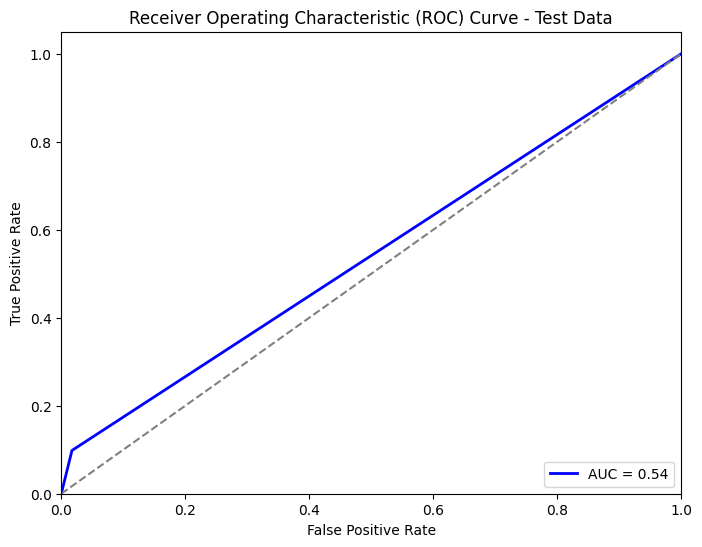

Confusion Matrix on Test Data:
[[4557   80]
 [1229  134]]


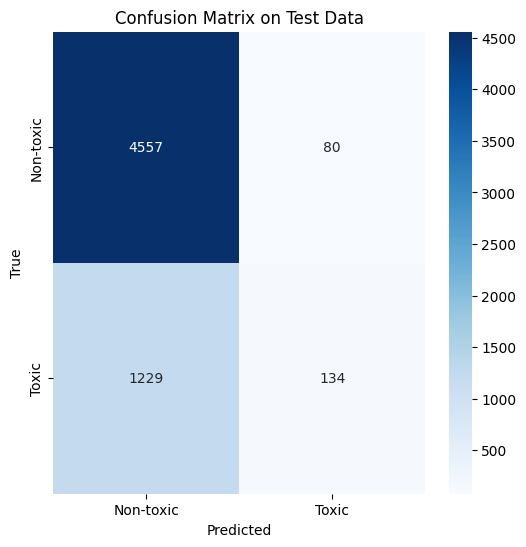

In [44]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import torch

y_pred_test = []
y_true_test = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, predicted = torch.max(outputs.logits, 1)

        y_pred_test.extend(predicted.cpu().numpy())
        y_true_test.extend(labels.cpu().numpy())

# Test Accuracy
test_accuracy = accuracy_score(y_true_test, y_pred_test)
print(f"Test Accuracy: {test_accuracy:.4f}")


print("Classification Report on Test Data:")
print(classification_report(y_true_test, y_pred_test))


roc_auc_test = roc_auc_score(y_true_test, [pred == 1 for pred in y_pred_test])
print(f"Test ROC-AUC Score: {roc_auc_test:.4f}")


fpr_test, tpr_test, thresholds_test = roc_curve(y_true_test, [pred == 1 for pred in y_pred_test])
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, color='blue', lw=2, label=f'AUC = {roc_auc_test:.2f}')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix on Test Data
cm_test = confusion_matrix(y_true_test, y_pred_test)
print("Confusion Matrix on Test Data:")
print(cm_test)


plt.figure(figsize=(6, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-toxic', 'Toxic'], yticklabels=['Non-toxic', 'Toxic'])
plt.title('Confusion Matrix on Test Data')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()